In [ ]:
# Download data
!pip install -q kaggle
from google.colab import files
files.upload()
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download -d 'andrewmvd/medical-mnist'
!unzip -q medical-mnist.zip -d data
!rm medical-mnist.zip

In [ ]:
# Installations
!pip install pytorch-lightning
# !pip install torchvision

In [21]:
# Imports
import os
from torchvision.datasets import ImageFolder
import torch
import matplotlib.pyplot as plt
import pytorch_lightning as pl
from pytorch_lightning import Trainer
from torchvision import transforms, datasets, models
from torch.utils.data import DataLoader
from pytorch_lightning.core.lightning import LightningModule

In [91]:
# Data preparation

class MedicalDataMNIST(pl.LightningDataModule):
    def __init__(self, num_workers=1):
      super().__init__()
      self.num_workers = num_workers
      self.labels_map = {0 : "AbdomenCT",
                         1 : "BreastMRI",
                         2 : "CXR",
                         3 : "ChestCT",
                         4 : "Hand",
                         5 : "HeadCT"}
      self.train_transform = transforms.Compose([transforms.ColorJitter(hue=.20, saturation=.20),
                                                 transforms.RandomHorizontalFlip(),
                                                 transforms.RandomVerticalFlip(),
                                                 transforms.RandomRotation(10),
                                                 transforms.ToTensor(),
                                                 transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                                                      std=[0.229, 0.224, 0.225])])
      
      self.val_test_transform = transforms.Compose([transforms.ToTensor(),
                                                    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                                                         std=[0.229, 0.224, 0.225])])
      
      # self.train_dims = None
      # self.vocab_size = 0

    def prepare_data(self):
      pass
      # called only on 1 GPU
      # ONLY DOWNLOAD!!!
      
    def setup(self, stage=None):
      # called on every GPU
      # vocab = load_vocab()
      # self.vocab_size = len(vocab)
      print("SETUP FUNCTION")

      if stage == 'fit' or stage is None:
        self.dataset = ImageFolder("./data/")
        test_size = int(0.1 * len(self.dataset)) # take 10% for test
        print(f"TRANSFORM 1 {self.dataset.transform}")

        self.train_set = torch.utils.data.Subset(self.dataset, range(test_size, len(self.dataset)))
        print(f"DATASET 1 {type(self.train_set.dataset)}")
        print("1-----------")
        print(self.train_set[0])
        val_size = int(0.2 * len(self.train_set))
        train_size = len(self.train_set) - val_size
        self.train_set, self.val_set = torch.utils.data.random_split(self.train_set, [train_size, val_size]) # CREATES ONE MORE SUBSET!!!!!
        
        self.train_set.dataset.dataset.transform = self.train_transform
        self.val_set.dataset.dataset.transform = self.val_test_transform
        print(f"DATASET 2 {type(self.train_set.dataset.dataset)}") # ERROR!!!!!!!!
        print("2--------")
        print(self.train_set[0])

      if stage == 'test' or stage is None:
        print("2ND IF")
        test_size = int(0.1 * len(self.dataset)) # take 10% for test
        self.test_set = torch.utils.data.Subset(self.dataset, range(test_size))
        self.test_set.dataset.transform = self.val_test_transform  

    def train_dataloader(self):
      return DataLoader(self.train_set, batch_size=64, shuffle=True, num_workers=self.num_workers)

    def val_dataloader(self):
      return DataLoader(self.val_set, batch_size=64, num_workers=self.num_workers)

    def test_dataloader(self):
      print("TEST DATALOADER")
      return DataLoader(self.test_set, batch_size=64, num_workers=self.num_workers)

    def visualize_dataset(self):
      # Visualizes dataset
      figure = plt.figure(figsize=(8, 8))
      cols, rows = 3, 3
      for i in range(1, cols * rows + 1):
          sample_idx = torch.randint(len(self.train_set), size=(1,)).item()
          img, label = self.train_set[sample_idx]
          # mean = torch.tensor([0.485, 0.456, 0.406])
          # std = torch.tensor([0.229, 0.224, 0.225])
          # img_dernimolized = img * std[:, None, None] + mean[:, None, None] 
          figure.add_subplot(rows, cols, i)
          plt.title(self.labels_map[label])
          plt.axis("off")
          plt.imshow(img.permute(1, 2, 0))
      plt.show()

    def visualize_dataloader(self):
      # Display image and label
      train_dataloader = self.train_dataloader()
      train_features, train_labels = next(iter(train_dataloader))
      print(f"Feature batch shape: {train_features.size()}")
      print(f"Labels batch shape: {train_labels.size()}")
      img = train_features[0]
      # mean = torch.tensor([0.485, 0.456, 0.406])
      # std = torch.tensor([0.229, 0.224, 0.225])
      # img_dernimolized = img * std[:, None, None] + mean[:, None, None]
      label = train_labels[0]
      plt.imshow(img.permute(1, 2, 0))
      plt.show()
      print(f"Label: {self.labels_map[label.item()]}")

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


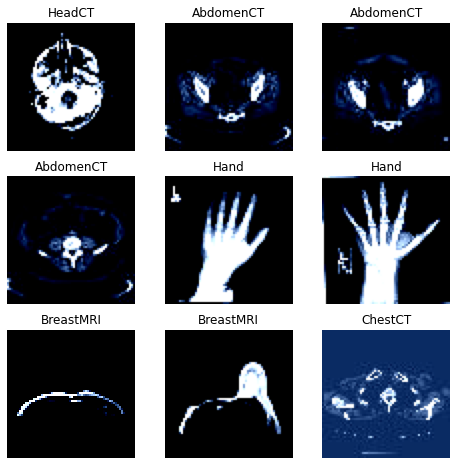

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Feature batch shape: torch.Size([64, 3, 64, 64])
Labels batch shape: torch.Size([64])


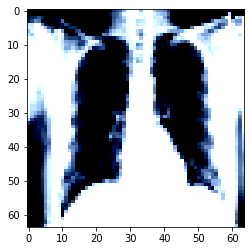

Label: CXR


In [27]:
dm = MedicalDataMNIST()
dm.setup()
dm.visualize_dataset()
dm.visualize_dataloader()

In [28]:
# Creating model

class MedicalMNIST(LightningModule):
    def __init__(self):
        super().__init__()
        self.model = models.efficientnet_b7(pretrained=True)
        self.model.classifier = torch.nn.Sequential(torch.nn.Dropout(p=0.2, inplace=False),
                                                    torch.nn.Linear(in_features=self.model.classifier[1].in_features, out_features=6))
        # num_ftrs = self.model.fc.in_features
        # self.model.fc = torch.nn.Linear(num_ftrs, 6)
        
        
    def forward(self, x):
        x = self.model(x)
        return x

    def training_step(self, batch, batch_idx):
        x, y = batch
        logits = self.model(x)
        loss = torch.nn.functional.cross_entropy(logits, y)
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self.model(x)
        loss = torch.nn.functional.cross_entropy(y_hat, y)
        self.log("val_loss", loss)

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=1e-3)

In [93]:
# MAIN
# Number of cpus and gpus
NUM_DATALOADER_WORKERS = os.cpu_count()
print(f"Number of cpus: {NUM_DATALOADER_WORKERS}")
NUM_GPUS = torch.cuda.device_count() if torch.cuda.is_available() else None
print(f"Number of gpus: {NUM_GPUS}")

# Train
medical_mnist_data = MedicalDataMNIST(num_workers=NUM_DATALOADER_WORKERS)
# medical_mnist_data.setup()
model = MedicalMNIST()
trainer = Trainer(gpus=NUM_GPUS, max_epochs=4)
trainer.fit(model, datamodule=medical_mnist_data)

Number of cpus: 2
Number of gpus: 1


KeyboardInterrupt: ignored